# 调包与参数

In [ ]:
from datacleanv2 import *
from SetRNN import *
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from collections import Counter # 用于统计计数的工具
import time # 用于计时
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils # 用于处理变长序列，如填充和打包
from torch.utils.data import Dataset, DataLoader # PyTorch 数据加载工具
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # 进度条库，使用 tqdm.tqdm
import random
import pyreadstat
import copy # 用于复制模型参数或列表
import matplotlib.pyplot as plt # 用于绘图
import seaborn as sns # 用于更美观的统计图，特别是热力图
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EARLY_ITER_BATCH_THRESHOLD = 3 # 在前 3 轮迭代中使用部分批次 (适应总迭代 10)
EARLY_ITER_BATCH_PERCENT = 0.3

# 超参数和常量定义
NUM_MAIN_MODELS = 3 # 主要的聚类模型数量
NUM_COMBINED_SETTINGS = 23 # combined_setting 的总类别数 (0-124)
EMBEDDING_DIM = 8 # combined_setting 的嵌入向量维度，可调整
HIDDEN_SIZE = 64   # RNN 隐藏层大小，可调整
NUM_RNN_LAYERS = 2 # RNN 层数
# 注意: TIME_LOSS_SCALER 可能需要根据实际 delta_t 的规模重新调整
TIME_LOSS_SCALER = 1 # time delta_t MSE 损失的缩放因子，需要根据实际损失值大小调整
TOTAL_EM_ITERATIONS = 10 # EM 迭代总次数 (根据要求修改为 10)
CONVERGENCE_THRESHOLD = 0.05 # 收敛阈值，分配改变的序列比例低于此值时停止 (5%)

# 干扰项处理参数
NUM_RAND_SEQUENCES = 250 # 干扰项的已知数量
INTERFERENCE_CLUSTER_LABEL = 3 # 将干扰项分配到的簇的索引 (0, 1, 2 是主簇，3 是干扰簇)
INTERFERENCE_DETECTION_START_ITER = 2 # 从第 5 轮迭代 (索引 4) 的 E 步开始检测干扰项
# 检测干扰项的高损失阈值：需要根据训练中观察到的损失值范围来调整
# 如果一个序列在所有模型上的平均损失超过这个阈值，则可能被认为是干扰项。
# ！！！重要参数，需要根据实际运行观察的损失值调整！！！
# 在模拟数据上运行一次，观察损失值的分布，尤其是 rand_label 序列的损失。
HIGH_AVG_LOSS_THRESHOLD = 0.5 ## <--- !!! 初始值，请务必根据实际情况调整 !!!

# M 步训练参数 (每个 EM 迭代中的训练 epochs)
# epochs 计划表：根据迭代次数使用不同数量的 epochs
EPOCH_SCHEDULE = [1] * 5 + [2]* 5 # 示例：前 3 轮迭代训练 2 epoch，接下来 7 轮训练 5 epoch (适应总迭代 10)
BATCH_SIZE = 32 # M 步训练时的批次大小
# 在早期迭代中是否只使用部分批次来加速训练
EARLY_ITER_BATCH_THRESHOLD = 3 # 在前 3 轮迭代中使用部分批次 (适应总迭代 10)
EARLY_ITER_BATCH_PERCENT = 0.3 # 在启用部分批次训练时使用的批次比例 (30%)

# 函数

In [24]:
def LossCalculate(loaded_list,final_assignment_list,Model,models):
    '''
    参数
        Loaded_list:载入的数据list,其中元素为数据框与一个字符串,数据框有time和combined_setting两个行,长度不小于3。
        final_assignment_list:在rnn cluster中每个序列分配的模型的索引,长度与loaded_list相同
        Model:一个RNN评估模型,在所有数据上训练得到
        models:一个列表,作为RNN分类模型,元素为rnn cluster过程中产生的RNN模型
    返回
        total_loss_list,setting_loss_list,time_loss_list:双层list,储存每一个序列的每一步的损失值,分别为总和、setting列和time列的损失值。第i个元素的第j个元素即为第i个“output序列”
        的第j个delta_T和第j个setting的损失。
    使用第t步的设置和第t步到第t+1步的时间差作为输入,预测第t+1步的设置和第t+1步到t+2步的时间差
    '''
    #计算每个序列的损失
    setting_loss_list=[[None for _ in range(len(models))] for _ in range(len(loaded_list))]
    time_loss_list=[[None for _ in range(len(models))] for _ in range(len(loaded_list))]
    for i in range(len(loaded_list)):
        seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
        seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
        time_criterion = nn.MSELoss(reduction= "sum")
        setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
        if final_assignment_list[i] >= len(models):
            setting_loss_list[i] = [[0]]*len(models)
            time_loss_list[i] = [[0]]*len(models)
            continue

        #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
        #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
        deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
        setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

        deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
        setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

        input_len = seq_time.shape[0] - 2#输出输出的长度
        length = torch.tensor([input_len])
        for j in range(len(models)):
            model = models[j]
            
            #模型预测
            predict_deltaT, predict_setting,_ = model(deltaT_inputs, setting_inputs, length)
            
            #计算损失
            seq_time_loss_list=[time_criterion(predict_deltaT.squeeze(0)[i], deltaT_targets.squeeze(0)[i]).item() for i in range(predict_deltaT.squeeze(0).shape[0])]
            seq_setting_loss_list=[setting_criterion(predict_setting.squeeze(0)[i].unsqueeze(0), setting_targets.squeeze(0)[i].unsqueeze(0)).item() for i in range(predict_setting.squeeze(0).shape[0])]
        
            setting_loss_list[i][j]=seq_setting_loss_list
            time_loss_list[i][j]=seq_time_loss_list
    
    #total_loss_list代表每个列表每一步的总损失
    total_loss_list = [[[setting_loss_list[i][j][k]+ time_loss_list[i][j][k] for k in range(len(setting_loss_list[i][j]))] for j in range(len(setting_loss_list[i]))]for i in range(len(setting_loss_list)) ]
    #计算每个序列的最小损失
    min_setting_loss_list = [[min([setting_loss_list[i][j][k] for j in range(len(setting_loss_list[i]))]) for k in range(len(setting_loss_list[i][0]))] for i in range(len(setting_loss_list))]
    min_time_loss_list = [[min([time_loss_list[i][j][k] for j in range(len(time_loss_list[i]))]) for k in range(len(time_loss_list[i][0]))] for i in range(len(time_loss_list))]
    min_total_loss_list = [[min([total_loss_list[i][j][k] for j in range(len(total_loss_list[i]))]) for k in range(len(total_loss_list[i][0]))] for i in range(len(total_loss_list))]
    return min_total_loss_list,min_setting_loss_list,min_time_loss_list

In [6]:
def ThresholdCalculate(total_loss_list,setting_loss_list,time_loss_list,threshold):
    '''
    参数:
        total_loss_list,setting_loss_list,time_loss_list:双层list,储存每一个序列的每一步的损失值,分别为总和、setting列和time列的损失值。第i个元素的第j个元素即为第i个“output序列”
        的第j个delta_T和第j个setting的损失。
        threshold:一个百分比值,代表要被删掉的序列的比例
    返回:
        setting_threshold,time_threshold,total_threshold:三个阈值,分别为setting列,time列和总损失的阈值,低于该阈值的序列将被删除;
        total_step_length:所有序列总的步骤数
    '''
    setting_loss_distribution=[item for list_item in setting_loss_list for item in list_item]
    time_loss_distribution=[item for list_item in time_loss_list for item in list_item]
    total_loss_distribution=[item for list_item in total_loss_list for item in list_item]

    setting_threshold = np.percentile(setting_loss_distribution, threshold)
    time_threshold = np.percentile(time_loss_distribution, threshold)
    total_threshold = np.percentile(total_loss_distribution, threshold)

    total_step_length=len(total_loss_distribution)
    
    return setting_threshold,time_threshold,total_threshold,total_step_length

In [8]:
def Prune(loaded_list,outliers,i,final_assignment_list,models):
    '''
    功能：将loaded_list中第i个序列的outliers中标记的异常点删除,并返回删除后的数据张量
    参数
        Loaded_list:载入的数据list,其中元素为数据框与一个字符串,数据框有time和combined_setting两个行,长度不小于3。
        outliers:一个列表,元素为元组(i,j),代表第i个序列的第j个步骤被认为是异常值,需要被删除
        i:当前是第i个序列,用于获取索引
        final_assignment_list:在rnn cluster中每个序列分配的模型的索引,长度与loaded_list相同
        models:一个列表,作为RNN分类模型,元素为rnn cluster过程中产生
    返回
        如果返回
            None,则continue
        否则返回
            pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets, pruned_length:分别为被删除后的时间间隔和setting的输入和输出张量,以及数据长度张量
    '''
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    
    if final_assignment_list[i] >= len(models):
        return None

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])
    
    #复制原始输入和目标张量，以便在删除异常点后进行修剪,将张量转换为列表（保留二维结构）,存入“pruned_...类型_输入/输出_list”中
    pruned_deltaT_inputs_list, pruned_setting_inputs_list, pruned_deltaT_targets_list, pruned_setting_targets_list= deltaT_inputs.clone().tolist(), setting_inputs.clone().tolist(), deltaT_targets.clone().tolist(), setting_targets.clone().tolist()
    indices_to_remove = [y for _, y in outliers if _ ==i]# 从outlier中提取所有序列标号为i的异常点（即第一个元素为i的数组),忽略x，只取y
    indices_to_remove = sorted(list(set(indices_to_remove)),reverse=True)  # 去重,降序排序(先删后面的，避免改变索引位置),indices_to_remove是储存第i个序列中需要删除的索引列表,注意sorted和.sort的区别
    #***测试用待删print(i,indices_to_remove)

    # 如果没有可删除的，则直接返回None
    if not indices_to_remove:
        return None
    
    # 如果所有步骤都是异常点，则跳过
    # ***是否要记录所有步骤都异常的序列的总数**？
    if len(pruned_deltaT_inputs_list[0]) == len(indices_to_remove):
        #***print("序列",i,"的所有步骤均为异常点，跳过")#提示均为异常点
        return -1
    for index in indices_to_remove:
        # 检查索引index是否在有效范围内
        if 0 <= index < len(pruned_deltaT_inputs_list[0]):# 删除被标记的步骤 <bug:只删去了t_input的异常点,忘记了其他的>
            del pruned_deltaT_inputs_list[0][index]
            del pruned_setting_inputs_list[0][index]
            del pruned_deltaT_targets_list[0][index]
            del pruned_setting_targets_list[0][index]
        else:
            # 可选：处理索引越界情况（例如打印警告或忽略）
            print(f"警告: 索引 {index} 超出范围，忽略删除")
            # 或者直接忽略

    pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets = torch.tensor(pruned_deltaT_inputs_list).to(device),torch.tensor(pruned_setting_inputs_list).to(device), torch.tensor(pruned_deltaT_targets_list).to(device), torch.tensor(pruned_setting_targets_list).to(device)# 现在，pruned_()_() 就是删除异常点后的数据链,<bug:忘记使用to(device)>
    pruned_length = torch.tensor([pruned_deltaT_inputs.shape[1]])#pruned_length为删除后的长度，从数据中取，并转化为张量
    return pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets,pruned_length

    #***检验用待删print(pruned_deltaT_inputs_list.shape,pruned_length, pruned_setting_inputs.shape[1])


In [ ]:
def Reclassify(loaded_list,models,final_assignment_list,outliers):
    '''
    参数:
        loaded_list:载入的数据list,其中元素为数据框与一个字符串,数据框有time和combined_setting两个行,长度不小于3。
        models:一个列表,作为RNN分类模型,元素为rnn cluster过程中产生的RNN模型
        final_assignment_list:在rnn cluster中每个序列分配的模型的索引,长度与loaded_list相同
        outliers:一个列表,元素为元组(i,j),代表第i个序列的第j个步骤被认为是异常值,需要被删除
    返回:
        changed_seq:一个列表,储存被重新分类的序列的索引
        Null_seq:一个列表,储存被删除所有步骤的序列的索引
    '''
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    changed_seq=[]
    Null_seq=[]
    for i in range(len(loaded_list)):#第i个序列
        pruned_data = Prune(loaded_list, outliers, i, final_assignment_list, models)
        #使用Prune函数删除异常点,返回删除后的数据序列
        if pruned_data is None:
            continue
        if pruned_data == -1:
            Null_seq.append(i)
            continue
        pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets, pruned_length = pruned_data
        
        #使用所有模型分别计算损失
        model_loss = [0] * len(models) # 初始化每个模型的损失列表
        for j in range(len(models)):
            model = models[j]
            #模型预测
            pruned_predict_deltaT, pruned_predict_setting,_ = model(pruned_deltaT_inputs, pruned_setting_inputs, pruned_length)

            #计算损失,seq代表按每一步计损失并编入列表
            pruned_seq_time_loss_list=[time_criterion(pruned_predict_deltaT.squeeze(0)[i], pruned_deltaT_targets.squeeze(0)[i]).item() for i in range(pruned_predict_deltaT.squeeze(0).shape[0])]
            pruned_seq_setting_loss_list=[setting_criterion(pruned_predict_setting.squeeze(0)[i].unsqueeze(0), pruned_setting_targets.squeeze(0)[i].unsqueeze(0)).item() for i in range(pruned_predict_setting.squeeze(0).shape[0])]

            model_loss[j] = sum(pruned_seq_setting_loss_list)+ sum(pruned_seq_time_loss_list) # 计算剪后序列i在模型j上的总损失
            #***测试用待删print(model_loss[j])

        min_modelloss = min(model_loss)
        min_modelindex = model_loss.index(min_modelloss)#找出剪后的最佳模型
        if min_modelindex != final_assignment_list[i] and final_assignment_list[i] < len(models):#若与原分配不同，则打印并记录
            #***用于提示：print("序列",i,"的最佳模型由",final_assignment_list[i],"变为",min_modelindex)
            changed_seq.append(i)
        #else:
        #    ***测试用待删print("模型损失:",model_loss,"序号不变",final_assignment_list[i])#<bug:在print()立马加入print(model_loss)会输出None>
    return changed_seq,Null_seq
    

In [ ]:
def LossPrune(loaded_list,final_assignment_list,models,threshold,total_loss_list,setting_loss_list,time_loss_list):
    '''
    参数
        Loaded_list:载入的list,其中元素为数据框与一个字符串,数据框有time和combined_setting两个行,长度不小于3。
        final_assignment_list:在rnn cluster中每个序列分配的模型的索引,长度与loaded_list相同
        models:一个列表,作为RNN分类模型,元素为rnn cluster过程中产生的RNN模型
        threshold:一个百分比值,代表要被删掉的序列的比例
        total_loss_list,setting_loss_list,time_loss_list:双层list,储存每一个序列的每一步的损失值,分别为总和、setting列和time列的损失值。第i个元素的第j个元素即为第i个“output序列”
    返回
        被删改的序列个数、分类改变的序列的个数、被完全删去的序列数
    '''
    setting_threshold,time_threshold,total_threshold,total_step_length=ThresholdCalculate(total_loss_list,setting_loss_list,time_loss_list,threshold)#计算每种损失的阈值
    outliers = [(i, j) for i, chain in enumerate(total_loss_list) for j, loss in enumerate(chain) if loss < total_threshold]#找出所有异常值,储存为(i,j)的元组,代表第i个序列的第j个步骤被认为是异常值,需要被删除
    
    print("共从",total_step_length,"个步骤中检测到",len(outliers),"个异常值")
    changed_seq,Null_seq=Reclassify(loaded_list,models,final_assignment_list,outliers)#找出重新分类之后被改变的序列

    print("压缩比例:",threshold,";类别改变比例",len(changed_seq)/len(loaded_list))
    print("{:<10}".format("总序列数"),len(loaded_list))
    print("{:<15}".format("被重新分类数"),len(set([i[0] for i in outliers])))
    print("{:<10}".format("被改变类别数"),len(changed_seq))

    return len(set([i[0] for i in outliers])),len(changed_seq),len(Null_seq)

In [85]:

#绘制百分比堆积图
def plot_percentage_stacked(thresholds, changed_seqnum, Null_seqnum, unchanged_seqnum):
    """
    绘制百分比堆积图
    
    参数:
    thresholds: 横轴阈值列表
    changed_seqnum: 底部序列
    Null_seqnum: 中间序列
    unchanged_seqnum: 顶部序列
    """
    # 转换为百分比
    total = np.array(changed_seqnum) + np.array(Null_seqnum) + np.array(unchanged_seqnum)
    changed_percent = np.array(changed_seqnum) / total * 100
    Null_percent = np.array(Null_seqnum) / total * 100
    unchanged_percent = np.array(unchanged_seqnum) / total * 100

    # 创建堆积图
    plt.figure(figsize=(10, 6))

    # 绘制堆积区域（从下到上：changed, Null, unchanged）
    plt.fill_between(thresholds, 0, changed_percent, label='Changed', alpha=0.8, color='#FF9999')
    plt.fill_between(thresholds, changed_percent, changed_percent + Null_percent, label='Null', alpha=0.8, color='#66B2FF')
    plt.fill_between(thresholds, changed_percent + Null_percent, 100, label='Unchanged', alpha=0.8, color='#99FF99')

    # 添加标签和标题
    plt.xlabel('Thresholds')
    plt.ylabel('Percentage (%)')
    plt.title('Percentage Stacked Area Chart')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 设置y轴范围为0-100%
    plt.ylim(0, 100)
    
    # 显示图表
    plt.tight_layout()
    plt.show()


# 主程序

In [68]:
thresholds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 98, 99] # 压缩比例列表

## Traffic

In [69]:

NUM_COMBINED_SETTINGS = 23
with open('LoadedList_Traffic.pkl', 'rb') as f:  # 'rb' 表示二进制读取模式
    loaded_list = pickle.load(f)  # 从文件读取并反序列化#载入数据
final_assignment_list= np.load("Final_assignments_Traffic.npy")

models = [SettingPredictorRNN(embedding_dim=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_rnn_layers=NUM_RNN_LAYERS, num_categories=NUM_COMBINED_SETTINGS).to(device) for _ in range(NUM_MAIN_MODELS)]
models[0] = torch.load("model1_traffic.pth",weights_only=False)
models[1] = torch.load("model2_traffic.pth",weights_only=False)   
models[2] = torch.load("model3_traffic.pth",weights_only=False)
Model = torch.load("TotalModel_traffic.pth",weights_only=False)


In [82]:
total_loss_list,setting_loss_list,time_loss_list=LossCalculate(loaded_list,final_assignment_list,Model,models)#计算损失值

共从 791979 个步骤中检测到 79198 个异常值
压缩比例: 10 ;类别改变比例 0.03342920106077018
总序列数       26773
被重新分类数          19833
被改变类别数     895
共从 791979 个步骤中检测到 158396 个异常值
压缩比例: 20 ;类别改变比例 0.06779217868748366
总序列数       26773
被重新分类数          23634
被改变类别数     1815
共从 791979 个步骤中检测到 237594 个异常值
压缩比例: 30 ;类别改变比例 0.10185634781309529
总序列数       26773
被重新分类数          25013
被改变类别数     2727
共从 791979 个步骤中检测到 316792 个异常值
压缩比例: 40 ;类别改变比例 0.1349867403727636
总序列数       26773
被重新分类数          25664
被改变类别数     3614
共从 791979 个步骤中检测到 395989 个异常值
压缩比例: 50 ;类别改变比例 0.17289806895006163
总序列数       26773
被重新分类数          26056
被改变类别数     4629
共从 791979 个步骤中检测到 475187 个异常值
压缩比例: 60 ;类别改变比例 0.20214395099540583
总序列数       26773
被重新分类数          26296
被改变类别数     5412
共从 791979 个步骤中检测到 554385 个异常值
压缩比例: 70 ;类别改变比例 0.23478877974078363
总序列数       26773
被重新分类数          26449
被改变类别数     6286
共从 791979 个步骤中检测到 633583 个异常值
压缩比例: 80 ;类别改变比例 0.2794606506555111
总序列数       26773
被重新分类数          26561
被改变类别数     7482
共从 791979 个步骤中检测到 712781 个异常

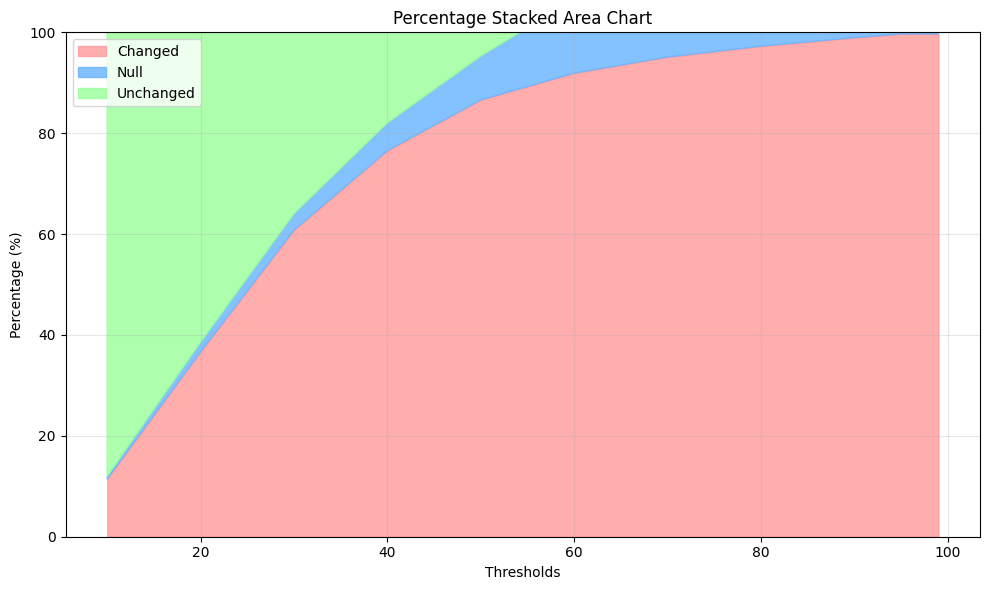

In [ ]:
total_seqnum=[len(loaded_list)]*len(thresholds)
reclassified_seqnum=[0]*len(thresholds)
changed_seqnum=[0]*len(thresholds)
Null_seqnum =[0]*len(thresholds)

for i,threshold in enumerate(thresholds):
    reclassified_seqnum[i],changed_seqnum[i],Null_seqnum[i]=LossPrune(loaded_list,final_assignment_list,models,threshold, total_loss_list,setting_loss_list,time_loss_list)#删除损失值最低的
unchanged_seqnum = [total_num - reclassified_num - Null_num for total_num,reclassified_num,Null_num in zip(total_seqnum,reclassified_seqnum,Null_seqnum)]


In [84]:
changed_seqnum

[895, 1815, 2727, 3614, 4629, 5412, 6286, 7482, 9286, 10150, 4850, 2350]

In [1]:

plot_percentage_stacked(thresholds, changed_seqnum, Null_seqnum, unchanged_seqnum)


NameError: name 'plot_percentage_stacked' is not defined

## Climate

In [ ]:
NUM_COMBINED_SETTINGS = 125
with open('LoadedList_Climate.pkl', 'rb') as f:  # 'rb' 表示二进制读取模式
    loaded_list = pickle.load(f)  # 从文件读取并反序列化#载入数据
final_assignment_list= np.load("Final_assignments_Climate.npy")

models = [SettingPredictorRNN(embedding_dim=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_rnn_layers=NUM_RNN_LAYERS, num_categories=NUM_COMBINED_SETTINGS).to(device) for _ in range(NUM_MAIN_MODELS)]
models[0] = torch.load("model1.pth",weights_only=False)
models[1] = torch.load("model2.pth",weights_only=False)   
models[2] = torch.load("model3.pth",weights_only=False)
Model = torch.load("TotalModel.pth",weights_only=False)

In [ ]:
total_loss_list,setting_loss_list,time_loss_list=LossCalculate(loaded_list,final_assignment_list,Model,models)#计算损失值
total_seqnum=[len(loaded_list)]*len(thresholds)
reclassified_seqnum=[0]*len(thresholds)
changed_seqnum=[0]*len(thresholds)
Null_seqnum =[0]*len(thresholds)

for i,threshold in enumerate(thresholds):
    reclassified_seqnum[i],changed_seqnum[i],Null_seqnum[i]=LossPrune(loaded_list,final_assignment_list,models,threshold, total_loss_list,setting_loss_list,time_loss_list)#删除损失值最低的


共从 411695 个步骤中检测到 41170 个异常值
压缩比例: 10 ;类别改变比例 0.047818313234678736
总序列数       26287
被重新分类数          14596
被改变类别数     1257
共从 411695 个步骤中检测到 82339 个异常值
压缩比例: 20 ;类别改变比例 0.07383877962490965
总序列数       26287
被重新分类数          18670
被改变类别数     1941
共从 411695 个步骤中检测到 123509 个异常值
压缩比例: 30 ;类别改变比例 0.09506600220641381
总序列数       26287
被重新分类数          20511
被改变类别数     2499
共从 411695 个步骤中检测到 164678 个异常值
压缩比例: 40 ;类别改变比例 0.11621714155285882
总序列数       26287
被重新分类数          21770
被改变类别数     3055
共从 411695 个步骤中检测到 205847 个异常值
压缩比例: 50 ;类别改变比例 0.14223760794308973
总序列数       26287
被重新分类数          22731
被改变类别数     3739
共从 411695 个步骤中检测到 247017 个异常值
压缩比例: 60 ;类别改变比例 0.1708829459428615
总序列数       26287
被重新分类数          23479
被改变类别数     4492
共从 411695 个步骤中检测到 288186 个异常值
压缩比例: 70 ;类别改变比例 0.21554380492258532
总序列数       26287
被重新分类数          24185
被改变类别数     5666
共从 411695 个步骤中检测到 329356 个异常值
压缩比例: 80 ;类别改变比例 0.27473656179860767
总序列数       26287
被重新分类数          24863
被改变类别数     7222
共从 411695 个步骤中检测到 370525 个

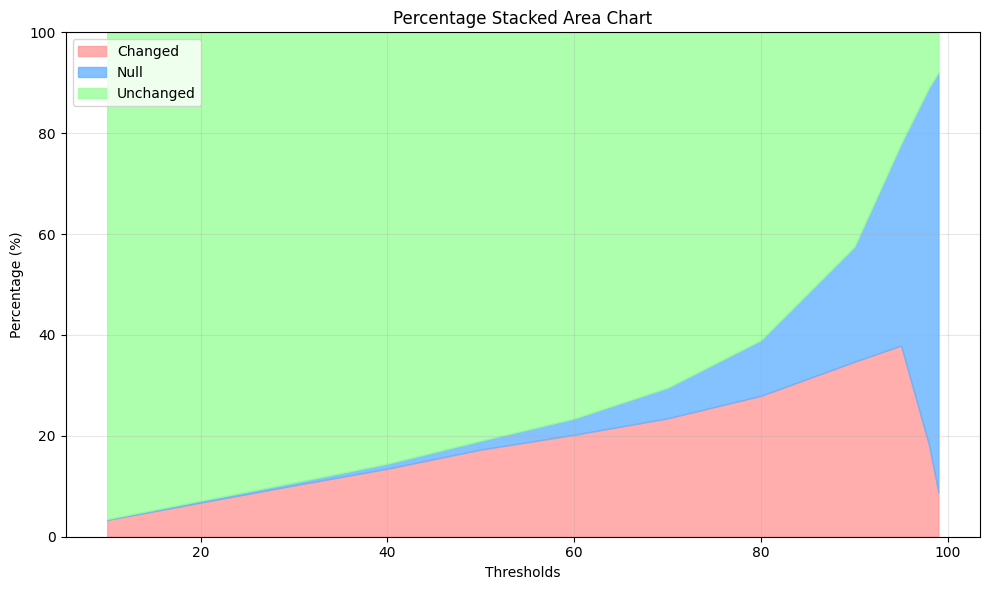

In [87]:
unchanged_seqnum = [total_num - changed_num - Null_num for total_num,changed_num,Null_num in zip(total_seqnum,changed_seqnum,Null_seqnum)]

plot_percentage_stacked(thresholds, changed_seqnum, Null_seqnum, unchanged_seqnum)


## Ticket

In [ ]:
NUM_COMBINED_SETTINGS = 13
with open('LoadedList_Tickets.pkl', 'rb') as f:  # 'rb' 表示二进制读取模式
    loaded_list = pickle.load(f)  # 从文件读取并反序列化#载入数据
final_assignment_list= np.load("Final_assignments_Tickets.npy")

models = [SettingPredictorRNN(embedding_dim=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_rnn_layers=NUM_RNN_LAYERS, num_categories=NUM_COMBINED_SETTINGS).to(device) for _ in range(NUM_MAIN_MODELS)]
models[0] = torch.load("model1_tickets.pth",weights_only=False)
models[1] = torch.load("model2_tickets.pth",weights_only=False)   
models[2] = torch.load("model3_tickets.pth",weights_only=False)
Model = torch.load("TotalModel_tickets.pth",weights_only=False)

In [ ]:
total_loss_list,setting_loss_list,time_loss_list=LossCalculate(loaded_list,final_assignment_list,Model,models)#计算损失值
total_seqnum=[len(loaded_list)]*len(thresholds)
reclassified_seqnum=[0]*len(thresholds)
changed_seqnum=[0]*len(thresholds)
Null_seqnum =[0]*len(thresholds)

for i,threshold in enumerate(thresholds):
    reclassified_seqnum[i],changed_seqnum[i],Null_seqnum[i]=LossPrune(loaded_list,final_assignment_list,models,threshold, total_loss_list,setting_loss_list,time_loss_list)#删除损失值最低的


共从 411695 个步骤中检测到 41170 个异常值
压缩比例: 10 ;类别改变比例 0.047818313234678736
总序列数       26287
被重新分类数          14596
被改变类别数     1257
共从 411695 个步骤中检测到 82339 个异常值
压缩比例: 20 ;类别改变比例 0.07383877962490965
总序列数       26287
被重新分类数          18670
被改变类别数     1941
共从 411695 个步骤中检测到 123509 个异常值
压缩比例: 30 ;类别改变比例 0.09506600220641381
总序列数       26287
被重新分类数          20511
被改变类别数     2499
共从 411695 个步骤中检测到 164678 个异常值
压缩比例: 40 ;类别改变比例 0.11621714155285882
总序列数       26287
被重新分类数          21770
被改变类别数     3055
共从 411695 个步骤中检测到 205847 个异常值
压缩比例: 50 ;类别改变比例 0.14223760794308973
总序列数       26287
被重新分类数          22731
被改变类别数     3739
共从 411695 个步骤中检测到 247017 个异常值
压缩比例: 60 ;类别改变比例 0.1708829459428615
总序列数       26287
被重新分类数          23479
被改变类别数     4492
共从 411695 个步骤中检测到 288186 个异常值
压缩比例: 70 ;类别改变比例 0.21554380492258532
总序列数       26287
被重新分类数          24185
被改变类别数     5666
共从 411695 个步骤中检测到 329356 个异常值
压缩比例: 80 ;类别改变比例 0.27473656179860767
总序列数       26287
被重新分类数          24863
被改变类别数     7222
共从 411695 个步骤中检测到 370525 个

In [ ]:
unchanged_seqnum = [total_num - reclassified_num - Null_num for total_num,reclassified_num,Null_num in zip(total_seqnum,reclassified_seqnum,Null_seqnum)]

plot_percentage_stacked(thresholds, changed_seqnum, Null_seqnum, unchanged_seqnum)
